This code was originally written by Simon Williams (https://github.com/siwill22) and has been slightly altered by me.

It plots the plate hierarchy of a plate model on a globe to show the visualisation of relationships between diferent blocks/plates.  It only needs a rotation file and continental polygons. Topologies can be used to make a complete plot if desired.

Referneces 

Domeier, M. and Torsvik, T.H., 2014. Plate tectonics in the late Paleozoic. Geoscience Frontiers, 5(3), pp.303-350.

Matthews, K.J., Maloney, K.T., Zahirovic, S., Williams, S.E., Seton, M. and Müller, R.D., 2016. Global plate boundary evolution and kinematics since the late Paleozoic. Global and Planetary Change, 146, pp.226-250.

In [1]:
import pygplates
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
%matplotlib inline

import plate_pairs
date_line_wrapper = pygplates.DateLineWrapper(0)

In [2]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/General_plate_reconstruction/Sample_data/'

#Domeier and Torsvik (2014)
DT14_rotation_model = pygplates.RotationModel('%sDT14_rotations.rot' % basedir)
DT14_polygons = pygplates.FeatureCollection('%sDT14_polygons.gpml' % basedir)
DT14_topologies = ['%sDT14_ridge.gpml' % basedir,
              '%sDT14_subduction.gpml' % basedir,
              '%sDT14_topologies.gpml' % basedir,
              '%sDT14_transform.gpml' % basedir]

#Matthews et al. (2016)
Mat16_rotation_model = pygplates.RotationModel('%sMat16_410-0Ma.rot' % basedir)
Mat16_polygons = pygplates.FeatureCollection('%sMat16_PresentDay_ContinentalPolygons.gpml' % basedir)
Mat16_topologies = ['%sMat16_Mesozoic-Cenozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_Paleozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_TopologyBuildingBlocks.gpml' % basedir]

recon_time = 350

[[503, 715], [401, 1, 0], [407, 113, 103], [154, 101], [601, 1, 0], [709, 701], [288, 701], [801, 802], [802, 709], [291, 701], [420, 401], [805, 802], [806, 868, 833, 801], [303, 302], [304, 305], [305, 302], [306, 304], [311, 302], [1001, 1, 0], [315, 302], [702, 802], [501, 702], [505, 503], [580, 1, 0], [582, 505], [201, 701], [714, 701], [715, 701], [504, 503], [430, 1, 0], [215, 201], [804, 802], [602, 701], [603, 801], [604, 602], [606, 616], [599, 603], [101, 1, 0], [102, 101], [103, 101], [616, 505], [124, 120], [1002, 1, 0], [108, 101], [701, 1, 0], [302, 301, 101], [375, 302], [120, 101], [121, 102]]


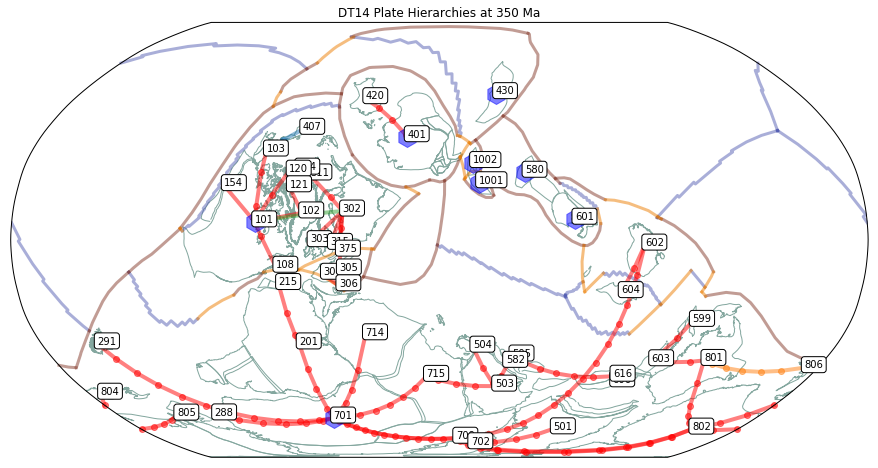

In [4]:
#DT14 first

reconstructed_polygons = []
resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(DT14_topologies,DT14_rotation_model,resolved_topologies,recon_time,shared_boundary_sections)
pygplates.reconstruct(DT14_polygons,DT14_rotation_model,reconstructed_polygons,recon_time)


uniq_plate_pairs_from_rotations = plate_pairs.get_unique_plate_pairs_from_rotation_model(DT14_rotation_model,recon_time)

uniq_plates_from_static_polygons = plate_pairs.get_unique_plate_ids_from_reconstructed_features(reconstructed_polygons)

chains = plate_pairs.get_plate_chains(uniq_plates_from_static_polygons,uniq_plate_pairs_from_rotations)

print chains

data_crs = ccrs.Geodetic()
projection = ccrs.Robinson()    
cm = plt.get_cmap('viridis')
plt.figure(figsize=(16,8))
ax = plt.axes(projection=projection)
ax.set_global()
for chain in chains:
    if chain[-1]==0:
        p0 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[0])
        ax.plot(p0[1],p0[0],'bh',markersize=20,transform=data_crs,zorder=4,alpha=0.5)
        ax.text(p0[1],p0[0],str(chain[0]),transform=data_crs,zorder=5,
                bbox=dict(facecolor='white', edgecolor='k', boxstyle='round'))
    else: 
        p0 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[0])
        p1 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[-1])

        if (len(p0)>0) & (len(p1)>0):
            if len(chain)==2:
                ax.plot([p0[1],p1[1]],[p0[0],p1[0]],'-ro',linewidth=4,transform=data_crs,zorder=2,alpha=0.5)
            else:
                ax.plot([p0[1],p1[1]],[p0[0],p1[0]],'-o',linewidth=4,transform=data_crs,zorder=2,alpha=0.5)
            ax.text(p0[1],p0[0],str(chain[0]),transform=data_crs,zorder=3,
                    bbox=dict(facecolor='white', edgecolor='k', boxstyle='round'))
            
for polygon in reconstructed_polygons:
    polygon_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry()) #make sure they are all actually polyogns
    wrapped_coastlines = date_line_wrapper.wrap(polygon_geom, 1)
    for wrapped_coastline in wrapped_coastlines:
            wrapped_coastlines_lat = []
            wrapped_coastlines_lon = []
            for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
                wrapped_coastline_lat_lon = wrapped_coastline_point.get_latitude(), wrapped_coastline_point.get_longitude()
                wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
                wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())
            ax.plot(wrapped_coastlines_lon, 
                    wrapped_coastlines_lat, color='#84a79f', linewidth=1, transform=data_crs, zorder=0)
            
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:        
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_lats_plot = []
                mor_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_lats_plot.append(wrapped_point.get_latitude())
                    mor_lons_plot.append(wrapped_point.get_longitude())
                ax.plot(mor_lons_plot, 
                        mor_lats_plot, color='#545eb3', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)

    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                trans_lats_plot = []
                trans_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    trans_lats_plot.append(wrapped_point.get_latitude())
                    trans_lons_plot.append(wrapped_point.get_longitude())                    
                ax.plot(trans_lons_plot,
                        trans_lats_plot, color='#ec7d00', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)

    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                sub_lats_plot = []
                sub_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    sub_lats_plot.append(wrapped_point.get_latitude())
                    sub_lons_plot.append(wrapped_point.get_longitude())                    
                ax.plot(sub_lons_plot,
                        sub_lats_plot, color='#853a2b', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)
                

                
ax.set_title('DT14 Plate Hierarchies at 350 Ma')
ax.set_global()

[[518, 529, 606], [522, 715], [7701, 715], [103, 101], [606, 616], [61501, 615], [61502, 61501], [701, 70, 4, 1, 0], [601, 602], [602, 701], [603, 647], [604, 602], [613, 612], [612, 602], [101, 714], [615, 801], [616, 801], [108, 101], [109, 714], [120, 101], [121, 122], [122, 123], [123, 124], [124, 120], [28800, 701], [3202, 304], [3203, 304], [647, 606], [154, 101], [709, 701], [61601, 616], [698, 801], [714, 715], [702, 802], [706, 714], [715, 701], [201, 714], [802, 701], [43300, 42100, 101], [736, 780, 698], [28900, 701], [16104, 101], [3307, 715], [16111, 101], [673, 647], [301, 101], [67350, 673], [283, 290], [801, 802], [290, 201], [291, 283], [804, 802], [813, 804], [302, 301], [304, 305], [305, 302], [306, 304], [311, 302], [3062, 3063], [319, 301], [375, 302], [890, 801], [833, 801], [401, 301], [50601, 506], [430, 401], [60405, 60404], [3063, 304], [61405, 736], [60401, 604], [60403, 604], [60404, 60403], [501, 802], [503, 709], [505, 503], [506, 505]]


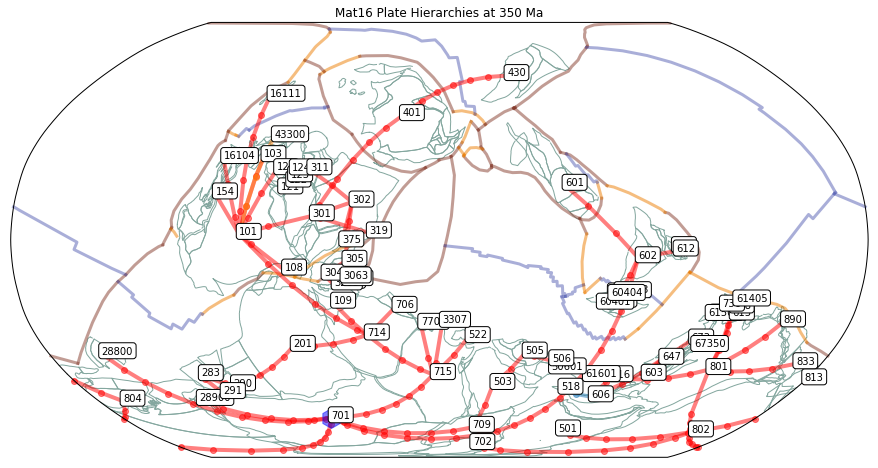

In [5]:
#DT14 first

reconstructed_polygons = []
resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(Mat16_topologies,Mat16_rotation_model,resolved_topologies,recon_time,shared_boundary_sections)
pygplates.reconstruct(Mat16_polygons,Mat16_rotation_model,reconstructed_polygons,recon_time)


uniq_plate_pairs_from_rotations = plate_pairs.get_unique_plate_pairs_from_rotation_model(Mat16_rotation_model,recon_time)

uniq_plates_from_static_polygons = plate_pairs.get_unique_plate_ids_from_reconstructed_features(reconstructed_polygons)

chains = plate_pairs.get_plate_chains(uniq_plates_from_static_polygons,uniq_plate_pairs_from_rotations)

print chains

data_crs = ccrs.Geodetic()
projection = ccrs.Robinson()    
cm = plt.get_cmap('viridis')
plt.figure(figsize=(16,8))
ax = plt.axes(projection=projection)
ax.set_global()
for chain in chains:
    if chain[-1]==0:
        p0 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[0])
        ax.plot(p0[1],p0[0],'bh',markersize=20,transform=data_crs,zorder=4,alpha=0.5)
        ax.text(p0[1],p0[0],str(chain[0]),transform=data_crs,zorder=5,
                bbox=dict(facecolor='white', edgecolor='k', boxstyle='round'))
    else: 
        p0 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[0])
        p1 = plate_pairs.GetPolygonCentroid(reconstructed_polygons,chain[-1])

        if (len(p0)>0) & (len(p1)>0):
            if len(chain)==2:
                ax.plot([p0[1],p1[1]],[p0[0],p1[0]],'-ro',linewidth=4,transform=data_crs,zorder=2,alpha=0.5)
            else:
                ax.plot([p0[1],p1[1]],[p0[0],p1[0]],'-o',linewidth=4,transform=data_crs,zorder=2,alpha=0.5)
            ax.text(p0[1],p0[0],str(chain[0]),transform=data_crs,zorder=3,
                    bbox=dict(facecolor='white', edgecolor='k', boxstyle='round'))
            
for polygon in reconstructed_polygons:
    polygon_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry()) #make sure they are all actually polyogns
    wrapped_coastlines = date_line_wrapper.wrap(polygon_geom, 1)
    for wrapped_coastline in wrapped_coastlines:
            wrapped_coastlines_lat = []
            wrapped_coastlines_lon = []
            for wrapped_coastline_point in wrapped_coastline.get_exterior_points():
                wrapped_coastline_lat_lon = wrapped_coastline_point.get_latitude(), wrapped_coastline_point.get_longitude()
                wrapped_coastlines_lat.append(wrapped_coastline_point.get_latitude())
                wrapped_coastlines_lon.append(wrapped_coastline_point.get_longitude())
            ax.plot(wrapped_coastlines_lon, 
                    wrapped_coastlines_lat, color='#84a79f', linewidth=1, transform=data_crs, zorder=0)
            
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:        
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_lats_plot = []
                mor_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_lats_plot.append(wrapped_point.get_latitude())
                    mor_lons_plot.append(wrapped_point.get_longitude())
                ax.plot(mor_lons_plot, 
                        mor_lats_plot, color='#545eb3', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)

    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                trans_lats_plot = []
                trans_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    trans_lats_plot.append(wrapped_point.get_latitude())
                    trans_lons_plot.append(wrapped_point.get_longitude())                    
                ax.plot(trans_lons_plot,
                        trans_lats_plot, color='#ec7d00', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)

    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                sub_lats_plot = []
                sub_lons_plot = []
                for wrapped_point in wrapped_polyline.get_points():
                    sub_lats_plot.append(wrapped_point.get_latitude())
                    sub_lons_plot.append(wrapped_point.get_longitude())                    
                ax.plot(sub_lons_plot,
                        sub_lats_plot, color='#853a2b', transform=data_crs, linewidth=3, alpha=0.5, zorder=1)
                

                
ax.set_title('Mat16 Plate Hierarchies at 350 Ma')
ax.set_global()